# **Part A**
Count / Frequency based Naive Bayes Classifier

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 1. Complete the fit method in NaiveBayesClassifier (4 TODOs for log prior and log likelihood calculation).
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # // TODO: Calculate the log prior and store it in self.class_priors[c]
            # Calculate Class Prior P(C): log(P(C))
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0]/len(y_array))

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # // TODO: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # // TODO: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # // TODO: Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # // TODO: Complete the log probability calculation for the likelihood term
                # Add log likelihoods contribution (Log-Sum Trick):
                # log_prob += sum(count(w_i) * log(P(w_i|C)))

                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # // TODO: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)

        # // TODO: Return the final predictions array
        return np.array(y_pred)

In [2]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 2211861
Dev   samples: 28932
Test  samples: 29493
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [3]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # // TODO: Set appropriate ngram_range
        ngram_range=(1,2),
        # // TODO: Set appropriate min_df
        min_df=3
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # // TODO: Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # // TODO: Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # // TODO: Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # // TODO: Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 1429626
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [4]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# // TODO: Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")


=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7784
              precision    recall  f1-score   support

  BACKGROUND       0.56      0.54      0.55      2663
 CONCLUSIONS       0.65      0.75      0.69      4426
     METHODS       0.85      0.87      0.86      9751
   OBJECTIVE       0.60      0.62      0.61      2377
     RESULTS       0.88      0.80      0.84     10276

    accuracy                           0.78     29493
   macro avg       0.71      0.72      0.71     29493
weighted avg       0.78      0.78      0.78     29493

Macro-averaged F1 score: 0.7112


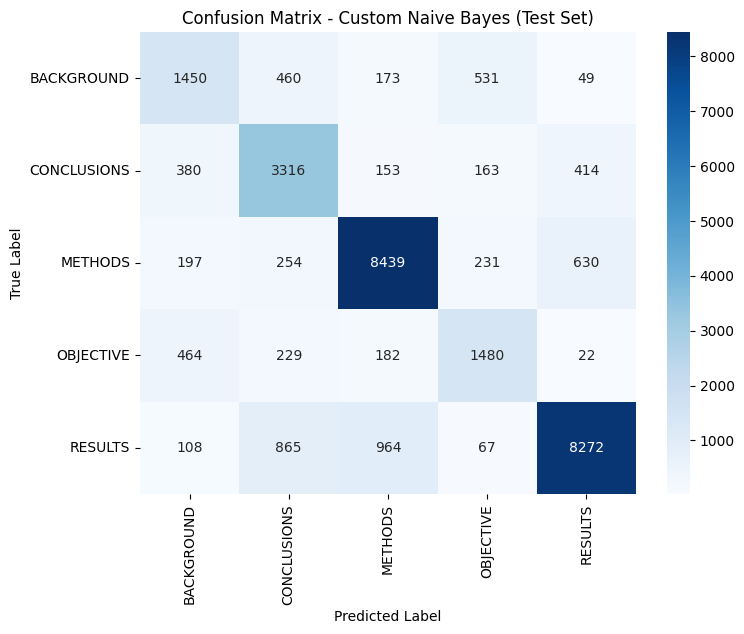

In [5]:
# Confusion Matrix on test set
    # // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
    # a visual confusion matrix (heatmap) for the predicted results.
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Custom Naive Bayes (Test Set)")
    plt.show()
else:
    print("Confusion Matrix cannot be generated — model predictions missing.")

# **Part B**
TF-IDF score based Classifier

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7384
              precision    recall  f1-score   support

  BACKGROUND       0.62      0.34      0.44      2663
 CONCLUSIONS       0.61      0.64      0.63      4426
     METHODS       0.76      0.86      0.81      9751
   OBJECTIVE       0.72      0.36      0.48      2377
     RESULTS       0.79      0.86      0.82     10276

    accuracy                           0.74     29493
   macro avg       0.70      0.61      0.63     29493
weighted avg       0.73      0.74      0.72     29493

Macro-averaged F1 score: 0.6345

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search complete.
Best Parameters: {'nb__alpha': 0.5, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
Best F1 Score: 0.5936


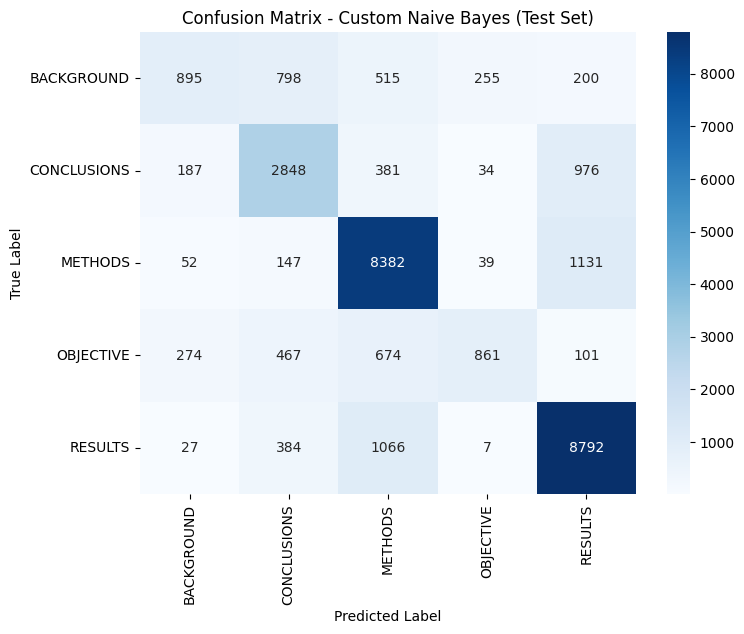

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================


# // TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
# Use standard initial parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# // TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


# Predict and evaluate on test set
# // TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
    pass
else:
    print("Initial model evaluation skipped: Predictions not available.")


# Hyperparameter Tuning using GridSearchCV

# // TODO: Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 5],
    'nb__alpha': [0.5, 1.0, 1.5]
}

# // TODO: Initialize GridSearchCV using the pipeline and param_grid.
# Ensure cv=3 and scoring='f1_macro' are used.
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Hyperparameter Tuning on Development Set...")
# // TODO: Fit the GridSearchCV object using the development data.
grid.fit(X_dev, y_dev)
print("Grid search complete.")


if grid is not None and hasattr(grid, 'best_params_'):
    # // TODO: Print the best parameters and the corresponding best cross-validation score.
    print("Best Parameters:", grid.best_params_)
    print(f"Best F1 Score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")

cm2 = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Custom Naive Bayes (Test Set)")
plt.show()

# **Part C**
Bayes Optimal Classifier

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# =======================================================
# TODO: Implement the following steps:
# 1. Define the five diverse hypothesis pipelines (H1 to H5) using TfidfVectorizer
#    and the specified classifiers (NB, LR, RF, DT, KNN).
# 2. Train each of the five hypotheses on the sampled training data.
# 3. Create a list of estimators for the VotingClassifier.
# 4. Initialize and fit the VotingClassifier (Bayes Optimal Classifier approximation).
# 5. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Sampling for faster training of multiple models (DO NOT CHANGE)
#
# *** STUDENT ACTION REQUIRED ***
# This section dynamically calculates the sample size based on the student's SRN.
# When running this cell, a prompt will appear asking for the full SRN.
#
BASE_SAMPLE_SIZE = 10000

FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        print("My SRN is" + FULL_SRN)
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Assuming X_train and y_train were loaded in Part A
# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one", "sample text two", "sample text three"])
    y_train = pd.Series(["BACKGROUND", "METHODS", "RESULTS"])
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

# Create the sampled training subset
# Ensure SAMPLE_SIZE does not exceed the size of the actual training data
effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

X_train_sampled = X_train[:SAMPLE_SIZE]
y_train_sampled = y_train[:SAMPLE_SIZE]
print(f"Using {len(X_train_sampled)} samples for training base models.")

# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines

# Multinomial Naive Bayes
h1_nb = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', MultinomialNB(alpha=1.0, fit_prior=False))])

# Logistic Regression
h2_lr = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))])

# Random Forest Classifier
h3_rf = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))])

# Decision Tree Classifier
h4_dt = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', DecisionTreeClassifier(max_depth=10, random_state=42))])

# K-Nearest Neighbors
h5_knn = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS512
My SRN isPES2UG23CS512
Using dynamic sample size: 10512
Actual sampled training set size used: 10512
Using 10512 samples for training base models.


In [8]:
# // TODO: Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop
for name, model in zip(hypothesis_names, hypotheses):
    model.fit(X_train_sampled, y_train_sampled)

print("All base models trained.")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


All base models trained.


In [9]:
# Implement and Evaluate the Bayes Optimal Classifier

# List of (name, estimator) tuples for the VotingClassifier
estimators = list(zip(hypothesis_names, hypotheses))

# Hard Voting (Majority Rule) for BOC approximation
# // TODO: Initialize the VotingClassifier using 'estimators'
boc_hard_voter = VotingClassifier(
    estimators=estimators,
    voting='hard',
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the sampled training data
if boc_hard_voter is not None:
    boc_hard_voter.fit(X_train_sampled, y_train_sampled)
    print("VotingClassifier fitting complete.")

# Make the final BOC prediction on the test set
# // TODO: Predict y_boc_pred using X_test
y_boc_pred = boc_hard_voter.predict(X_test)


Fitting the VotingClassifier (BOC approximation)...
VotingClassifier fitting complete.


In [10]:
# Evaluate the Bayes Optimal Classifier (BOC)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===")

if y_boc_pred is not None:
    # // TODO: Define Accuracy and Macro F1 Score

    boc_accuracy = accuracy_score(y_test, y_boc_pred)
    boc_f1 = f1_score(y_test, y_boc_pred, average='macro')

    print(f"BOC Accuracy: {boc_accuracy:.4f}")
    print(f"BOC Macro F1 Score: {boc_f1:.4f}")
    print(classification_report(y_test, y_boc_pred, target_names=target_names))


=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===
BOC Accuracy: 0.6795
BOC Macro F1 Score: 0.5563
              precision    recall  f1-score   support

  BACKGROUND       0.46      0.32      0.38      2663
 CONCLUSIONS       0.65      0.47      0.55      4426
     METHODS       0.61      0.93      0.74      9751
   OBJECTIVE       0.78      0.22      0.34      2377
     RESULTS       0.84      0.74      0.78     10276

    accuracy                           0.68     29493
   macro avg       0.67      0.53      0.56     29493
weighted avg       0.70      0.68      0.66     29493



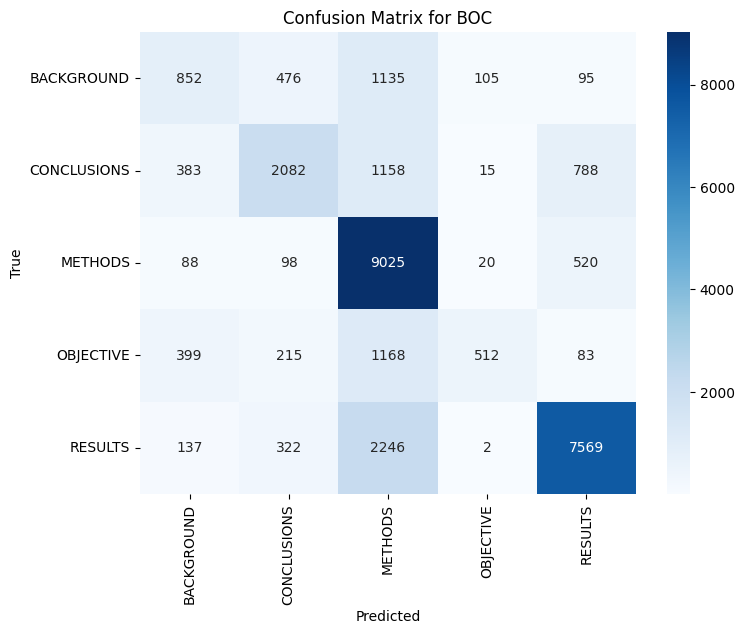

In [11]:
# // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
cm = confusion_matrix(y_test, y_boc_pred, labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for BOC')
plt.show()

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS512
Using dynamic sample size: 10512
Actual sampled training set size used: 10512

Training all base models...
Training NaiveBayes
Training LogisticRegression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training RandomForest
Training DecisionTree
Training KNN
All base models trained.

Using 8409 samples for sub-training and 2103 for validation (likelihood calc).
Evaluating log-likelihood on validation set for NaiveBayes...
  Log-likelihood: -1619.0088
Evaluating log-likelihood on validation set for LogisticRegression...
  Log-likelihood: -1437.7909
Evaluating log-likelihood on validation set for RandomForest...
  Log-likelihood: -1667.7678
Evaluating log-likelihood on validation set for DecisionTree...
  Log-likelihood: -2433.8278
Evaluating log-likelihood on validation set for KNN...
  Log-likelihood: -2761.1894

Posterior weights P(h | D) (normalized):
  NaiveBayes: 0.0000
  LogisticRegression: 1.0000
  RandomForest: 0.0000
  DecisionTree: 0.0000
  KNN: 0.0000

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) 

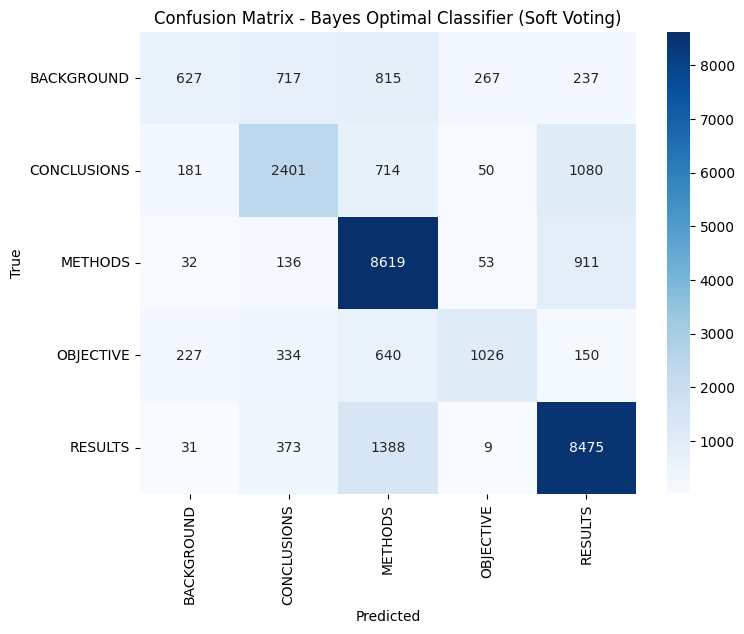

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation

# =======================================================
# TODO: Implement the following steps:
# 1. Train all five hypotheses on the sampled training data.
# 2. Compute the Posterior Weights P(h_i | D) using a validation split.
# 3. Fit the VotingClassifier using the sampled training data.
# 4. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        # Fallback if input is too short
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    # Fallback if SRN is not entered or format is incorrect
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1), # Using unigrams only to keep feature space small for diverse models
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest Classifier
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


# Training and BOC Implementation (STUDENT TASK)

# // TODO: Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop.
print("\nTraining all base models...")
for name, model in zip(hypothesis_names, hypotheses):
    print(f"Training {name}")
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")


# // TODO: Implement the Posterior Weight Calculation (P(h_i | D)).
# This requires splitting X_train_sampled into a small train_sub/val_sub set
# and calculating the validation log-likelihood for each model. Normalize these to get posterior_weights.
train_sub, val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42, stratify=y_train_sampled
)
print(f"\nUsing {len(train_sub)} samples for sub-training and {len(val_sub)} for validation (likelihood calc).")

log_likelihoods = []
eps = 1e-12  # numerical stability

for name, model in zip(hypothesis_names, hypotheses):
    print(f"Evaluating log-likelihood on validation set for {name}...")
    # predict_proba on validation set
    probs = model.predict_proba(val_sub)
    clf_classes = model.named_steps['clf'].classes_
    idx_map = np.array([np.where(clf_classes == lab)[0][0] for lab in y_val_sub])
    # extract the predicted probabilities assigned to the true labels
    true_probs = probs[np.arange(len(val_sub)), idx_map]
    # compute log-likelihood (sum log p(true_label | model))
    ll = np.sum(np.log(true_probs + eps))
    log_likelihoods.append(ll)
    print(f"  Log-likelihood: {ll:.4f}")

log_likelihoods = np.array(log_likelihoods)
max_ll = np.max(log_likelihoods)
weights_unnorm = np.exp(log_likelihoods - max_ll)
posterior_weights = weights_unnorm / np.sum(weights_unnorm)

print("\nPosterior weights P(h | D) (normalized):")
for name, w in zip(hypothesis_names, posterior_weights):
    print(f"  {name}: {w:.4f}")

posterior_weights = posterior_weights + 1e-12
posterior_weights = posterior_weights / np.sum(posterior_weights)

# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# // TODO: Predict y_pred using X_test, and then calculate and visualize evaluation metrics.
y_pred = boc_soft_voter.predict(X_test)


# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    # Example calculations:
    # // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Macro F1 : {f1_score(y_test, y_pred, average='macro'):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))


    all_labels = np.unique(np.concatenate([y_train_sampled.unique(), y_test.unique()]))
    cm = confusion_matrix(y_test, y_pred, labels=all_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Bayes Optimal Classifier (Soft Voting)")
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")